In [1]:
import os
import torch, json
import numpy as np
from transformers import AutoProcessor, Blip2ForConditionalGeneration
from accelerate import infer_auto_device_map

from PIL import Image

In [2]:
# Init
with open('../dataset/train.json') as f:
    train_anno = json.load(f)

folder_path='../dataset/train'
image_names=[]
file_names = os.listdir(folder_path)
for file_name in file_names:
    if file_name[:3]=='IMG':
        image_names.append(file_name)

index=[100]

def generate_text(image_name,folder_path,processor,model,print_flag=True,plot_flag=False):
    prompt = "this is a picture of"

    # Load information of specified image
    for image_info in train_anno['images']:
        if image_info['file_name'] == image_name:
            image_id=image_info['id']
            height=image_info['height']
            width=image_info['width']
            break

    category_id=[]
    bbox=[]
    for anno in train_anno['annotations']:
        if anno['image_id']==image_id:    
            category_id.append(anno['category_id'])
            category_id=list(set(category_id))

            bbox.append(anno['bbox'] )

    category=[]
    for cat in category_id:
        for cat_info in train_anno['categories']:
            if cat_info['id']==cat:
                category.append(cat_info['name'])

    # Generate text
    im = Image.open(folder_path+f"/{image_name}").convert("RGB") # load image
    inputs = processor(im, text=prompt, return_tensors="pt").to("cuda", torch.float16)

    generated_ids = model.generate(**inputs, max_new_tokens=20)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    # Print result
    if print_flag:
        print("this is a picture of "+generated_text)
        print('answer:',end='')
        print(','.join(category))
        print(' ')

    # Show figure
    if plot_flag:
        scale=0.5
        display(im.resize((int(im.width * scale),int(im.height * scale))))
    
    return width,height,bbox,category,generated_text


def normalized_bbox(bboxes,width,height):
    bbox=[]
    for temp_bbox in bboxes:  
        xmin=temp_bbox[0]/width
        ymin=temp_bbox[1]/height
        xmax=(temp_bbox[0]+temp_bbox[2])/width
        ymax=(temp_bbox[1]+temp_bbox[3])/height
        bbox.append([xmin,ymin,xmax,ymax])
    return bbox

### Test different pretrained models
1. Test pretrained model: Salesforce/blip2-opt-2.7b

In [3]:
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", load_in_8bit=True)
device_map = infer_auto_device_map(model, no_split_module_classes=["OPTDecoderLayer"])


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

this is a picture of a starfish in a tank
answer:starfish
 


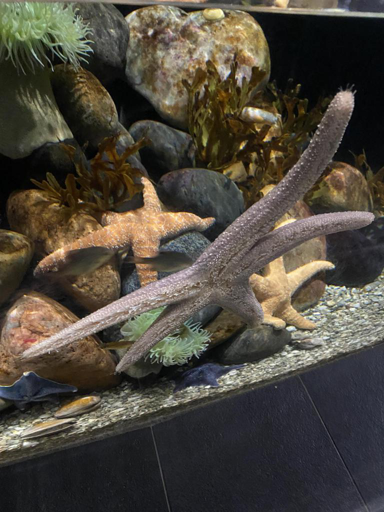

In [4]:
for i in index: #range(start_index,end_index):
    img=image_names[i]
    generate_text(img,folder_path,processor,model,plot_flag=True)

2. Test pretrained model: Salesforce/blip2-opt-6.7b-coco

In [3]:
torch.cuda.empty_cache()
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-6.7b-coco")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-6.7b-coco", load_in_8bit=True)
device_map = infer_auto_device_map(model, no_split_module_classes=["OPTDecoderLayer"])

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

this is a picture of a fish tank with a starfish and rocks
answer:starfish
 


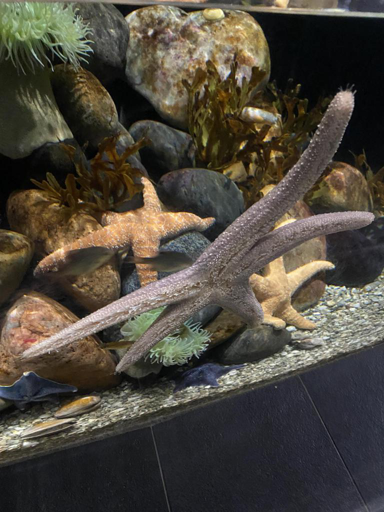

In [5]:
for i in index: #range(start_index,end_index):
    img=image_names[i]
    generate_text(img,folder_path,processor,model,plot_flag=True)

3. Test pretrained model: Salesforce/blip2-flan-t5-xl

In [3]:
torch.cuda.empty_cache()
processor = AutoProcessor.from_pretrained("Salesforce/blip2-flan-t5-xl")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xl", load_in_8bit=True)
device_map = infer_auto_device_map(model, no_split_module_classes=["OPTDecoderLayer"])

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

this is a picture of a starfish in an aquarium
answer:starfish
 


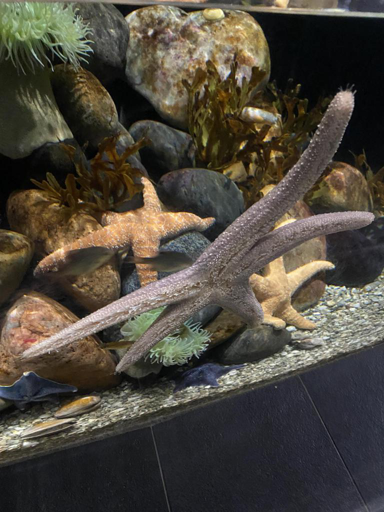

In [39]:
for i in index: #range(start_index,end_index):
    img=image_names[i]
    generate_text(img,folder_path,processor,model,plot_flag=True)

### Do image captioning for each image in ./dataset/train folder

In [4]:
# Choose 'Salesforce/blip2-opt-6.7b-coco' pretrained model to generate caption
output_json=[]

for img in image_names:
    output={}
    width,height,bboxes,category,generated_text=generate_text(img,folder_path,processor,model,print_flag=False)
    bbox=normalized_bbox(bboxes,width,height)

    output["image"]=img
    output["label"]=category
    output["height"]=height
    output["width"]=width
    output['bboxes']=bbox
    output["generated_text"]=generated_text
    output["prompt_w_label"]=generated_text+' ,'+' ,'.join(category)+', height:'+str(height)+', width:'+str(width)
    output["prompt_w_suffix"]=generated_text+' ,'+' ,'.join(category)+', ocean, undersea background, HD quality, highly detailed'

    output_json.append(output)

json_data = json.dumps(output_json, indent=4)
with open('image_captioning.json', 'w') as json_file:
    json_file.write(json_data)
